In [1]:
!pip install trulens==0.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.8 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/LMBTough/ABE-XAI.git
import os
os.chdir("ABE-XAI")

Cloning into 'ABE-XAI'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 193 (delta 18), reused 34 (delta 10), pack-reused 143 (from 2)
Receiving objects: 100% (193/193), 87.29 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2,FasterRCNN_ResNet50_FPN_V2_Weights
import torch
from torch import nn
import sys
from PIL import Image
sys.path.append('..')
import torch.nn.functional as F

import pickle

import copy

batch_data = pickle.load(open('examples/sample_data/batch_data.pkl', 'rb'))

sample_x, sample_y = batch_data
# Use the Faster R-CNN model for object detection
model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)  # Load pretrained Faster R-CNN model
model = model.cuda()

# Freeze batchnorm layers
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad = False
        m.bias.requires_grad = False

target_y = copy.deepcopy(sample_y)



for i in range(len(sample_y)):
    for k in sample_y[i].keys():
        sample_y[i][k] = sample_y[i][k].cuda()
        target_y[i][k] = target_y[i][k].cuda()
        if k == "labels":
            target_y[i][k] = torch.ones_like(sample_y[i][k])

sample_x,sample_y,target_y = sample_x[0],sample_y[0],target_y[0]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 176MB/s]


In [4]:
sample_x

tensor([[[0.6667, 0.6784, 0.6863,  ..., 0.2706, 0.2667, 0.2745],
         [0.6745, 0.6902, 0.6941,  ..., 0.2706, 0.2824, 0.2784],
         [0.6863, 0.6941, 0.6980,  ..., 0.2745, 0.2706, 0.2784],
         ...,
         [0.7373, 0.7176, 0.7569,  ..., 0.7294, 0.7294, 0.7333],
         [0.7294, 0.7333, 0.7294,  ..., 0.7765, 0.7647, 0.7294],
         [0.7294, 0.7333, 0.7294,  ..., 0.5059, 0.4941, 0.4196]],

        [[0.5333, 0.5569, 0.5647,  ..., 0.2980, 0.2980, 0.2784],
         [0.5529, 0.5686, 0.5725,  ..., 0.3020, 0.3137, 0.2941],
         [0.5647, 0.5725, 0.5765,  ..., 0.3059, 0.3020, 0.2941],
         ...,
         [0.7412, 0.7176, 0.7333,  ..., 0.6157, 0.6157, 0.6118],
         [0.7176, 0.7216, 0.7176,  ..., 0.5255, 0.4706, 0.3451],
         [0.7176, 0.7216, 0.7176,  ..., 0.2353, 0.2235, 0.1608]],

        [[0.2863, 0.3020, 0.3098,  ..., 0.1647, 0.1529, 0.1451],
         [0.3020, 0.3137, 0.3176,  ..., 0.1569, 0.1686, 0.1569],
         [0.3098, 0.3176, 0.3137,  ..., 0.1529, 0.1569, 0.

In [5]:
sample_x.shape

torch.Size([3, 426, 640])

In [6]:
target_y

{'boxes': tensor([[236.9800, 142.5100, 261.6800, 212.0100],
         [  7.0300, 167.7600, 156.3500, 262.6300],
         [557.2100, 209.1900, 638.5600, 287.9200],
         [358.9800, 218.0500, 414.9800, 320.8800],
         [290.6900, 218.0000, 352.5200, 316.4800],
         [413.2000, 223.0100, 443.3700, 304.3700],
         [317.4000, 219.2400, 338.9800, 230.8300],
         [412.8000, 157.6100, 465.8500, 295.6200],
         [384.4300, 172.2100, 399.5500, 207.9500],
         [512.2200, 205.7500, 526.9600, 221.7200],
         [493.1000, 174.3400, 513.3900, 282.6500],
         [604.7700, 305.8900, 619.1100, 351.6000],
         [613.2400, 308.2400, 626.1200, 354.6800],
         [447.7700, 121.1200, 461.7400, 143.0000],
         [549.0600, 309.4300, 585.7400, 399.1000],
         [350.7600, 208.8400, 362.1300, 231.3900],
         [412.2500, 219.0200, 421.8800, 231.5400],
         [241.2400, 194.9900, 255.4600, 212.6200],
         [336.7900, 199.5000, 346.5200, 216.2300],
         [321.2100, 23

In [7]:
# before peforimg any attack, We need to define the loss function
# loss function takes only one argument, which is the batch of data
# We can define the loss function as follows
def loss_fn(model,batch):
    # Forward pass through the Faster R-CNN model
    # The model expects a list of tensors (each tensor is a dictionary with boxes and labels)
    # Here, we assume sample_y is already in the correct format as a list of dictionaries
    # To avoid effect batchnorm, we need to deepcopy the model

    # Note: Faster R-CNN model in PyTorch returns a dictionary of losses
    sample_x, sample_y = batch
    loss_dict = model([sample_x], [sample_y])

    # Combine all losses (classification + bbox regression)
    # losses = sum(loss for loss in loss_dict.values())

    losses = loss_dict['loss_classifier']
    return losses

from functools import partial
loss_fn = partial(loss_fn, model) # now loss_fn takes only one argument

#### Attack

In [8]:
from abe.algorithm.attack import FGSM, PGD, BIM, MIFGSM, TIFGSM, DIFGSM, SINIFGSM, SSA

In [9]:
# first we need to define the attack task
from abe.task import AttackTask
from abe.type import ModelType

task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=False) # for targeted attack, set is_targeted=True

# then we can define the attack algorithm

attack = BIM(task,eps=32/255, alpha=2/255, steps=16) # BIM attack

adversarial_x = attack([sample_x, sample_y]) # all attack algorithms take a batch of data as input

targeted_task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=True)

targeted_attack = BIM(targeted_task,eps=32/255, alpha=2/255, steps=16) # BIM attack with targeted_task

targeted_adversarial_x = targeted_attack([sample_x, target_y]) # for targeted attack, the second element of the batch should be the target label

In [10]:
# Now we can plot the adversarial example

from abe.metric.visualization import plot_adversarial_sample

<Figure size 640x480 with 0 Axes>

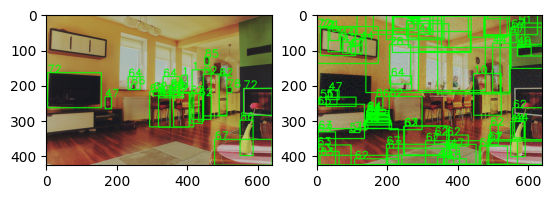

In [11]:
# To plot the adversarial example, we need to provide the original sample and the adversarial sample and forward function

def forward(batch):
    model.eval()
    x, _ = batch
    pred = model(x)
    model.train()
    threshold = 0.5
    scores = pred[0]['scores']
    boxes = pred[0]['boxes']
    labels = pred[0]['labels']
    keep = scores > threshold
    scores = scores[keep]
    boxes = boxes[keep]
    labels = labels[keep]
    return boxes, labels

# we should transform the input data to the correct format N, C, H, W


plot_adversarial_sample(forward,batch=[sample_x.unsqueeze(0),sample_y],adversarial_sample=adversarial_x.unsqueeze(0),model_type=ModelType.OBJECTDETECTION)

<Figure size 640x480 with 0 Axes>

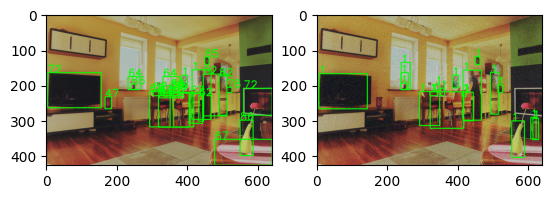

In [12]:
plot_adversarial_sample(forward,batch=[sample_x.unsqueeze(0),sample_y],adversarial_sample=targeted_adversarial_x.unsqueeze(0),model_type=ModelType.OBJECTDETECTION)

#### Explanation

In [13]:
from abe.algorithm.explanation import AMPE,IG, FastIG, SaliencyMap, SmoothGradient, MFABA

In [14]:
# first we need to define the explanation task
from abe.task import ExplanationTask

# Explanation task takes loss function and forward function as initialization arguments

def loss_fn(batch):
    # Forward pass through the Faster R-CNN model
    # The model expects a list of tensors (each tensor is a dictionary with boxes and labels)
    # Here, we assume sample_y is already in the correct format as a list of dictionaries
    # To avoid effect batchnorm, we need to deepcopy the model
    # Freeze batchnorm layers
    # Note: Faster R-CNN model in PyTorch returns a dictionary of losses
    sample_x, sample_y = batch
    loss_dict = model([sample_x], [sample_y])

    # Combine all losses (classification + bbox regression)
    # losses = sum(loss for loss in loss_dict.values())

    losses = loss_dict['loss_box_reg'] # use a specific box regression loss # not implemented in the current version, instead we use all box regression loss
    return losses

def forward(batch):
    return model(batch)

In [15]:
explanation_task = ExplanationTask(loss_fn=loss_fn, forward_fn=forward, model_type=ModelType.OBJECTDETECTION)

In [16]:
# then we can define the explanation algorithm

explanation = AMPE(explanation_task)

attribution = explanation([sample_x, sample_y])

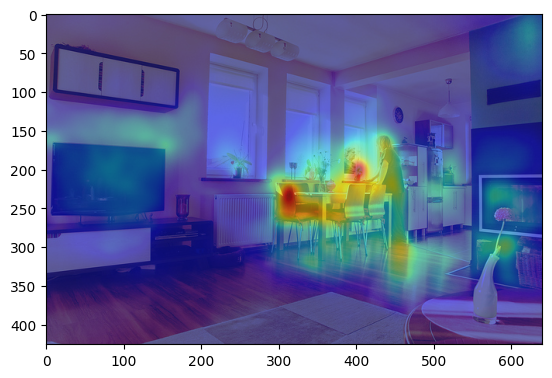

In [17]:
# Now we can plot the attribution map

from abe.metric.visualization import plot_explanation_heatmap

plot_explanation_heatmap(attribution, sample_x)